In [11]:
import kagglehub
muratkokludataset_rice_image_dataset_path = kagglehub.dataset_download('muratkokludataset/rice-image-dataset')

print('Data source import complete.')

Data source import complete.


In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import pathlib
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import MobileNetV2
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import plotly.express as px
from collections import Counter
import os
import json

import plotly.express as px
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

In [13]:
# Set seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Dataset path
data_dir = pathlib.Path("/kaggle/input/rice-image-dataset/Rice_Image_Dataset")
categories = ['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']
label_map = {i: cat for i, cat in enumerate(categories)}
reverse_label_map = {cat.lower(): i for i, cat in enumerate(categories)}

In [14]:
# Create model directory if not exists
os.makedirs("model", exist_ok=True)
# Save label_map for backend use
with open("model/label_map.json", "w") as f:
    json.dump(label_map, f)

In [17]:
# Load and preprocess images
X, y = [], []
max_images_per_class = 400  # Balanced loading

for category in categories:
    image_paths = list((data_dir / category).glob("*"))[:max_images_per_class]
    label = reverse_label_map[category.lower()]

    for img_path in image_paths:
        img = cv2.imread(str(img_path))
        if img is not None:
            img = cv2.resize(img, (224, 224))
            X.append(img)
            y.append(label)

In [18]:
# Convert to arrays and normalize
X = np.array(X).astype("float32") / 255.0
y = np.array(y)

In [19]:
# Shuffle before splitting
indices = np.arange(len(X))
np.random.shuffle(indices)
X, y = X[indices], y[indices]

In [20]:
# Train/val/test split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

print("Train:", X_train.shape, y_train.shape)
print("Val:", X_val.shape, y_val.shape)
print("Test:", X_test.shape, y_test.shape)

Train: (1400, 224, 224, 3) (1400,)
Val: (300, 224, 224, 3) (300,)
Test: (300, 224, 224, 3) (300,)


In [21]:
# Data augmentation
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=15,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator()

train_gen = train_datagen.flow(X_train, y_train, batch_size=32)
val_gen = val_datagen.flow(X_val, y_val, batch_size=32)

In [22]:
# MobileNetV2 as base model
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze base

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [23]:
# Model architecture
inputs = keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(256, activation='relu')(x)
x = keras.layers.Dropout(0.4)(x)
outputs = keras.layers.Dense(5, activation='softmax')(x)

model = keras.Model(inputs, outputs)

In [24]:
# Compile
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [25]:
# Callbacks
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.2)

In [26]:
# Train
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    callbacks=[early_stop, reduce_lr]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



Epoch 1/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - accuracy: 0.7237 - loss: 0.7292 - val_accuracy: 0.9567 - val_loss: 0.1228 - learning_rate: 0.0010
Epoch 2/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - accuracy: 0.9478 - loss: 0.1514 - val_accuracy: 0.9600 - val_loss: 0.0844 - learning_rate: 0.0010
Epoch 3/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - accuracy: 0.9596 - loss: 0.1225 - val_accuracy: 0.9433 - val_loss: 0.1469 - learning_rate: 0.0010
Epoch 4/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.9610 - loss: 0.1084 - val_accuracy: 0.9633 - val_loss: 0.0806 - learning_rate: 0.0010
Epoch 5/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 76s 2s/step - accuracy: 0.9551 - loss: 0.1154 - val_accuracy: 0.9700 - val_loss: 0.0675 - learning_rate: 0.0010
Epoch 6/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - accuracy: 0.9584 - loss: 0.1060 - val_accuracy: 0.9633 - val_loss: 0.0845 - learning_rate: 0.0010
Epoch 7/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.9695 - loss: 0.1033 - val_accuracy: 

In [27]:
# Fine-tune top layers
base_model.trainable = True
model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Lower learning rate for fine-tuning
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [28]:
# Save model
model.save("rice_model.keras")
print("✅ Final model saved as rice_model.keras")

✅ Final model saved as rice_model.keras


In [29]:
# Evaluate
print("\n📊 Evaluation on Test Set:")
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc * 100:.2f}%")


📊 Evaluation on Test Set:
10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 979ms/step - accuracy: 0.9699 - loss: 0.0690
Test Accuracy: 97.00%


In [30]:
# Predictions
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

10/10 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step


In [31]:
# Classification Report
print("\n📋 Classification Report:")
print(classification_report(y_test, y_pred, target_names=categories))


📋 Classification Report:
              precision    recall  f1-score   support

     Arborio       0.92      1.00      0.96        60
     Basmati       1.00      0.95      0.97        60
      Ipsala       1.00      0.98      0.99        60
     Jasmine       0.94      1.00      0.97        60
   Karacadag       1.00      0.92      0.96        60

    accuracy                           0.97       300
   macro avg       0.97      0.97      0.97       300
weighted avg       0.97      0.97      0.97       300



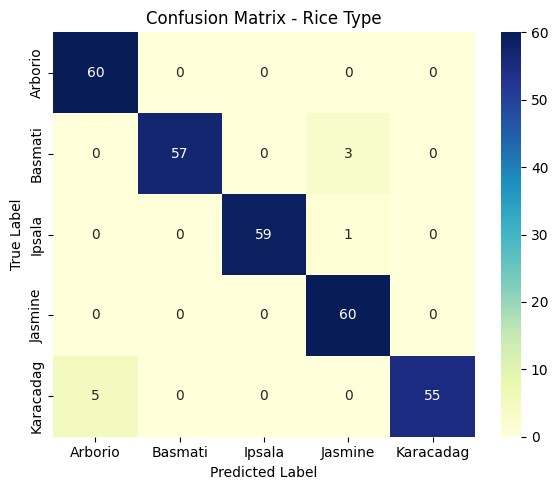

In [32]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=categories, yticklabels=categories, cmap="YlGnBu")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Rice Type")
plt.tight_layout()
plt.show()

In [33]:
from google.colab import files
files.download("rice_model.keras")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>